# Lab1
Welcome to the Turtlebot4 Orientation Lab. Here you will learn to:
* Read data from the robots services
* Drive the robot around
* Accuracy of the odometry

Next, just execute the code cells below in sequence, read the comments, the output, and see what happens.

Don't worry, you can modify this code as you like. First, let's confirm you know how to run the code.

In [1]:
# This text box is called a cell.
# In this environment, a Jupyter Python Notebook, it contains Python code.
# Click on the triangle left of this box (cell) to execute it.
# The output will appear below.
print(1+1)

2


# Load Robot wrapper and initialize ROS
While the Turtlebot4 works using ROS2, you are using a wrapper around
ROS2 to make things more straight forward. 

You can inspect the wrapper by opening the file [/opt/robohub/humble/lib/python3.10/site-packages/turtlebot4_wrapper/\_\_init__.py](/opt/robohub/humble/lib/python3.10/site-packages/turtlebot4_wrapper/\_\_init__.py)

In [2]:
import turtlebot4_wrapper

turtlebot4_wrapper.use_hardware()
# turtlebot4_wrapper.use_simulation()

# load ROS library
import rclpy
if not rclpy.ok():
    rclpy.init()

# Instantiate Wrapper. The subscribes and publishes the relevant topics and connects the actions.
if not "robot" in globals():
    robot = turtlebot4_wrapper.Robot()

Exception: ('VPN does not seem to be running, did you start it?:', AttributeError("'NoneType' object has no attribute 'groups'"))

# Example: Read data from topics: Battery charge state
Check Battery State. Note: 10% get you 10 minutes of runtime.


In [2]:
# Make sure we have fresh data by waiting for a new message
robot.battery_state_future = rclpy.Future()
robot.spin_until_future_completed(robot.battery_state_future)

# Pretty print the contents of the message
print("Battery {0:2.3}%, charging with {1:2.2}A".format(
    robot.last_battery_state_msg.percentage*100,
    robot.last_battery_state_msg.current
))

Battery 1e+02%, charging with -0.7A


In [3]:
# Read laser scan
robot.scan_future = rclpy.Future()
robot.spin_until_future_completed(robot.scan_future)
robot.last_scan_msg


sensor_msgs.msg.LaserScan(header=std_msgs.msg.Header(stamp=builtin_interfaces.msg.Time(sec=1692649990, nanosec=200373331), frame_id='rplidar_link'), angle_min=-3.1241393089294434, angle_max=3.1415927410125732, angle_increment=0.008714509196579456, time_increment=0.00018665297830011696, scan_time=0.1342034935951233, range_min=0.15000000596046448, range_max=12.0, ranges=[0.4950000047683716, 0.49300000071525574, 0.49300000071525574, 0.49000000953674316, 0.49000000953674316, 0.48899999260902405, 0.48899999260902405, 0.4880000054836273, 0.48899999260902405, 0.492000013589859, 0.49399998784065247, inf, inf, inf, 0.6439999938011169, 0.6439999938011169, 0.6399999856948853, inf, inf, inf, inf, 1.722000002861023, 1.722000002861023, inf, 1.4220000505447388, 1.4220000505447388, 1.3919999599456787, 1.3919999599456787, 1.3179999589920044, 1.25600004196167, 1.2280000448226929, inf, 1.0759999752044678, 1.0759999752044678, 1.0540000200271606, 1.0360000133514404, 0.9980000257492065, 0.9639999866485596, 

In [4]:
robot.odom_future = rclpy.Future()
robot.spin_until_future_completed(robot.odom_future)
robot.last_odom_msg.pose.pose


geometry_msgs.msg.Pose(position=geometry_msgs.msg.Point(x=3.557888703653589e-06, y=-2.5184288460877724e-05, z=1.227644759183022e-07), orientation=geometry_msgs.msg.Quaternion(x=-0.0004968613502569497, y=-0.018498696386814117, z=6.10650604357943e-05, w=0.9998287558555603))

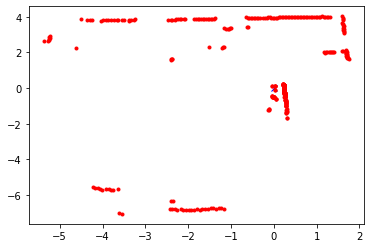

In [5]:
from matplotlib import pyplot as plt
# Plot robot position from odometry
# Use blue cross marker to designate the robot position
pose = robot.last_odom_msg.pose.pose
plt.plot([pose.position.x],[pose.position.y],'bx') # TODO: show robot front

# Plot lidar points from last message
def plot_lidar_scan_points(msg,pose):
    # Convert received lidar points into cartesian coordinates considering the current position from odometry
    import numpy
    points = [(numpy.cos(angle)*radius,numpy.sin(angle)*radius) for angle, radius \
              in zip(numpy.linspace(msg.angle_min,msg.angle_max,len(msg.ranges)),msg.ranges)]

    T = robot.reduce_transform_to_2D(robot.convert_odom_to_transform(pose))
    T_base_lidar = numpy.array([[ 2.22044605e-16, -1.00000000e+00, -4.00000000e-02],       [ 1.00000000e+00,  2.22044605e-16,  0.00000000e+00],       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
    # remove points which cannot be measured
    filtered_points = filter(lambda x: numpy.isfinite(x).all(),points)
    
    # display points in world frame
    transformed_points = [numpy.matmul(numpy.dot(T,T_base_lidar), numpy.vstack([ numpy.atleast_2d(x).T,numpy.ones((1,1)) ]) ) for x in filtered_points]
    plt.plot(
        [x[0] for x in transformed_points],
        [x[1] for x in transformed_points],'r.')

plot_lidar_scan_points(robot.last_scan_msg,pose)

Angle of the fitted line with respect to the x-axis: -0.20 radians
Distance to the wall: 1.55 meters


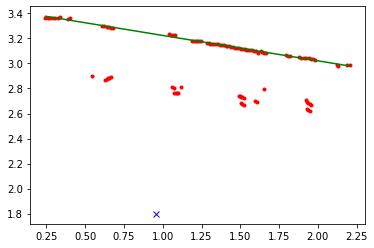

In [15]:
import numpy as np
from sklearn.linear_model import RANSACRegressor
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from geometry_msgs.msg import Twist
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize
import time

# Function to reduce 3D transformation to 2D
def reduce_transform_to_2D(transform):
    # Assuming transform is a 4x4 matrix
    return transform[:2, :2]

# Function to convert odometry to transformation
def convert_odom_to_transform(pose):
    # Convert the 2D pose (position and orientation) to a 3x3 homogeneous transformation matrix
    return np.array([
        [np.cos(pose.orientation.z), -np.sin(pose.orientation.z), pose.position.x],
        [np.sin(pose.orientation.z), np.cos(pose.orientation.z), pose.position.y],
        [0, 0, 1]
    ])

def rotate(angle):
        # Create a Twist message
        twist = Twist()

        # Set the angular velocity in the z-axis to achieve the desired rotation
        twist.angular.z = angle / abs(angle) * 0.5  # Adjust the value

        # Publish the message for a certain duration to achieve the desired rotation
        start_time = robot.get_clock().now()
        while robot.get_clock().now() - start_time < rclpy.time.Duration(seconds=abs(angle) / 0.5):
            robot.cmd_vel_publisher.publish(twist)
            time.sleep(0.1)  # Sleep for 100 ms
        # Stop the rotation
        twist.angular.z = 0.0
        robot.cmd_vel_publisher.publish(twist)
        robot.set_cmd_vel(0.1, 0.0, 0.2)

        
def plot_lidar_scan_points(msg, pose):
    points = [(np.cos(angle) * radius, np.sin(angle) * radius, 1) for angle, radius \
              in zip(np.linspace(msg.angle_min, msg.angle_max, len(msg.ranges)), msg.ranges)]
    
    T = convert_odom_to_transform(pose)
    
    # Remove points which cannot be measured
    filtered_points = filter(lambda x: np.isfinite(x).all(), points)

    transformed_points = [np.matmul(T, x) for x in filtered_points]
    transformed_points = [x[:2] for x in transformed_points] # Reduce the homogeneous coordinates back to 2D
    
     # Convert to array for clustering
    transformed_points_array = np.array(transformed_points)

    # Apply DBSCAN algorithm to cluster the points
    clustering = DBSCAN(eps=0.5, min_samples=5).fit(transformed_points_array)

    # Find the cluster with the most points (above threshold)
    threshold_value = 50 # Example threshold
    largest_cluster = []
    for cluster_id in set(clustering.labels_):
        if cluster_id == -1:
            continue # Ignore noise (-1 label)
        
        cluster_points = transformed_points_array[clustering.labels_ == cluster_id]
        if len(cluster_points) > threshold_value and len(cluster_points) > len(largest_cluster):
            largest_cluster = cluster_points

    plt.plot([x[0] for x in largest_cluster], [x[1] for x in largest_cluster], 'r.')

    return largest_cluster

T_base_lidar = np.array([[ 2.22044605e-16, -1.00000000e+00, -4.00000000e-02],       [ 1.00000000e+00,  2.22044605e-16,  0.00000000e+00],       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
# Assuming robot.last_odom_msg and robot.last_scan_msg contain the necessary information
pose = robot.last_odom_msg.pose.pose
plt.plot([pose.position.x], [pose.position.y], 'bx') # Robot position

transformed_points = plot_lidar_scan_points(robot.last_scan_msg, pose)
transformed_points_array = np.array(transformed_points)

# Extract X and Y coordinates
X = transformed_points_array[:, 0].reshape(-1, 1)
y = transformed_points_array[:, 1]
# Apply RANSAC algorithm to fit a line to the points
ransac = RANSACRegressor()
ransac.fit(X, y)

# Plot the line
line_X = np.array([np.min(X), np.max(X)])
line_y = ransac.predict(line_X.reshape(-1, 1))
plt.plot(line_X, line_y, 'g-') # Line in green color

# Determine the slope of the fitted line
m = (line_y[1] - line_y[0]) / (line_X[1] - line_X[0])

# Compute the angle of inclination to the x-axis in radians
theta_rad = np.arctan(m)
#theta_deg = theta_rad * (180 / np.pi)

print(f"Angle of the fitted line with respect to the x-axis: {theta_rad:.2f} radians")
# Calculate the distance between the robot and the wall
distance_to_wall = np.abs(line_y[0] - pose.position.y) / np.sqrt(1 + m ** 2)
print(f"Distance to the wall: {distance_to_wall:.2f} meters")

# Define target distance to the wall
target_distance = 0.5 # meters

# Calculate rotation angle based on the distance to the wall
if distance_to_wall > target_distance:
    rotation_angle = theta_rad
else:
    rotation_angle = np.pi - theta_rad

# Apply rotation to the robot
rotate(rotation_angle)

In [ ]:
T_base_lidar = np.array([[ 2.22044605e-16, -1.00000000e+00, -4.00000000e-02],       [ 1.00000000e+00,  2.22044605e-16,  0.00000000e+00],       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
# print(robot.last_scan_msg)
# # print(robot.last_odom_msg)# print(robot.reduce_transform_to_2D(robot.get_tf_transform("base_link","rplidar_link")))def get_distance(x1 , y1 , x2 ,y2):    return np.sqrt((x2-x1)**2+(y2-y1)**2)def is_not_rods(pt , x2 ,y2):    if get_distance(pt[0] ,pt[1] , x2, y2) >= 0.14:        return True    else:        return False# T_base_lidar = robot.reduce_transform_to_2D(robot.get_tf_transform("base_link","rplidar_link"))# Plot lidar points from last messagedef plot_lidar_scan_points_working(msg,pose):    # Convert received lidar points into cartesian coordinates considering the current position from odometry    import numpy    points = [(numpy.cos(angle)*radius,numpy.sin(angle)*radius) for angle, radius \
              in zip(numpy.linspace(msg.angle_min,msg.angle_max,len(msg.ranges)),msg.ranges)]    
# print(points[0:5])
    T = robot.reduce_transform_to_2D(robot.convert_odom_to_transform(pose))    # print(T)        # remove points which cannot be measured    filtered_points = filter(lambda x: numpy.isfinite(x).all(),points)
        # display points in world frame    transformed_points = [numpy.matmul(np.dot(T,T_base_lidar),        numpy.vstack([ numpy.atleast_2d(x).T,numpy.ones((1,1)) ]) ) for x in 
                          filtered_points]        # transformed_points = [pnt for pnt in transformed_points if abs(pnt[0]) <= 3 and abs(pnt[1]) <= 3]               # # transformed_points = [pnt for pnt in transformed_points if abs(pnt[0]) >= 0.0 and abs(pnt[1]) >= 0.095]      transformed_points = [pnt for pnt in transformed_points if is_not_rods(pnt , pose.position.x , pose.position.y )] 

    return transformed_points        transformed_points = plot_lidar_scan_points_working(robot.last_scan_msg,pose)plt.plot([pose.position.x],[pose.position.y],'bx') # TODO: show robot frontplt.plot(    [x[0] for x in transformed_points],    [x[1] for x in transformed_points],'r.')plt.ylim(-3.,3.)plt.xlim(-3.,3.)

In [ ]:
robot.reset_odometry()

In [ ]:
from geometry_msgs.msg import Twist
msg = Twist()
msg.linear.x = 0.1
msg.angular.z = 0.
robot.cmd_vel_publisher.publish(msg)

# Example: Drive the robot via teleoperation
First, undock the robot using a preprogrammed behavior. Then open the visualization to drive the robot using buttons. After you are done, dock the robot again.

In [7]:
robot.undock()

irobot_create_msgs.action.Undock_Result(is_docked=False)

In [12]:
robot.open_visualization()

ValueError: Unknown format code 'd' for object of type 'str'

In [11]:
print("You can additional move the robot with your phone:")
robot.open_visualization(open_url=False,mobile_layout=True,display_qrcode=True)

You can additional move the robot with your phone:


ValueError: Unknown format code 'd' for object of type 'str'

On the new webpage In the foxglove visualizer, you can drive the robot with panels in the bottom right hand corner. After you are done exploring, position the robot so that it is approximately 1-2m away from the dock and is pointing towards the dock.

In [ ]:
robot.dock()

# Example: Drive a square shape
In this example the robot automatically drives a square shape. While this is interesting to watch, it shows also some challenges. Before you execute this, mark the start position on the floor using tape as shown below (TODO: picture. Place your start position such that the robot has at least 0.5m space to the front and 0.5m to the left. Then execute the next cell. The code will also start a background logging process so you can analyze the data later.

In [8]:
# send_cmd_vel (forward_velocity, rotation_velocity, duration)
robot.reset_odometry() # make the robot think it is at position (0,0,0) 
robot.configure_logging(["/odom","/tf","/tf_static","/scan"]) # set topics which should be recorded
robot.start_logging() # start the background logging process
for iterations in range(2): # drive the square
    robot.set_cmd_vel(0.4, 0.0, 2.) # 0.1
    robot.set_cmd_vel(0.0, 0.5, 3.14)
    robot.set_cmd_vel(0.4, 0.0, 2.) # 0.1
    robot.set_cmd_vel(0.0, 0.5, 3.14)
    robot.set_cmd_vel(0.4, 0.0, 2.) # 0.1
    robot.set_cmd_vel(0.0, 0.5, 3.14)
    robot.set_cmd_vel(0.4, 0.0, 2.) # 0.1
    robot.set_cmd_vel(0.0, 0.5, 3.14)
logging_dir = robot.stop_logging()
log_data = robot.get_logging_data(logging_dir) # parse the logged data and import in python

KeyboardInterrupt: 

Executing the next cell will open the log data in the visualizer.

In [9]:
robot.open_logging_data_in_visualizer(logging_dir)
robot.delete_logging_data(logging_dir)

NameError: name 'logging_dir' is not defined

In [10]:
# Plot data in the notebook
print("Collected {} samples".format(len(log_data['/odom'])))
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge
fig,ax = plt.subplots(1)
ax.set_aspect('equal')
# TODO: decide if x forward is really the way to go
plt.xlim([-1.5,0.2])
plt.ylim([-0.2,1.5])
for msg in log_data['/odom'][::20]:
    T3D = robot.convert_odom_to_transform(msg[1].pose.pose)
    T2D = robot.reduce_transform_to_2D(T3D)
    circ = Circle((-T2D[1,2],T2D[0,2]),0.1) # TODO: correct radius
    circ.set_fill(False)
    ax.add_patch(circ)
    angle = robot.rotation_from_transform(T2D)
    import math
    angle = angle/math.pi*180
    wedge = Wedge((-T2D[1,2],T2D[0,2]),0.1, angle+180+45, angle+360-45)
    ax.add_patch(wedge)

NameError: name 'log_data' is not defined

From the experiment, please try to explain two aspect:
* Discrepancies between the commanded robot motion and the executed one
* Discrepancies between the measured motion and the one you observed
Try to come up with an answer and write it in the next field

# Use this field

Later, after you are done with this lab please save this notebook. Then commit the repository and push it. Detailled instructions will follow, but this is how you submit your work in this course.

# Example: Drive robot and aquire odometry
Tape measure, tape. Optional: Laser pointer.

* Tape two parallel lines `0.2m` apart on the floor. These are start and finish lines `0.2m`.
* Place the robot at the start line
* Read data from the Odometry topic
* Command the robot to drive `0.2m` straight
* Read data from the Odometry topic.
Did the robot travel `0.2m`? Where could the error come from?

Modify the experiment to investigate the behavior for rotation. Instead of the start and finish line attach a laser pointer to the base and aim it at a reference point. Command the robot to turn one full revolution.

Reading:
- Odometry sensor: TODO: find link
- Quaternions: https://en.wikipedia.org/wiki/Quaternion#Quaternions_and_the_space_geometry


In [ ]:
# Use preprogrammed behavior: Drive off the dock in a controlled way
robot.undock()

In [16]:
# Display raw data: Odometry based position
robot.odom_future = rclpy.Future()
pose1 = robot.spin_until_future_completed(robot.odom_future).pose.pose
print(pose1.position)
print(pose1.orientation)

geometry_msgs.msg.Point(x=0.9875290393829346, y=1.8079200983047485, z=0.013794180937111378)
geometry_msgs.msg.Quaternion(x=-0.002142574405297637, y=-0.004510119091719389, z=0.07286708801984787, w=0.9973291754722595)


In [17]:
# Drive with desired velocity command:
velocity_x = 0.1 # in m/s
velocity_phi = 0.0 # for rotation test use 0.5 rad/s
duration = 2.0 # in s
robot.set_cmd_vel(velocity_x, velocity_phi, duration)

In [18]:
# Display raw data: Odometry based position
robot.odom_future = rclpy.Future()
pose2 = robot.spin_until_future_completed(robot.odom_future).pose.pose
print(pose2.position)
print(pose2.orientation)

geometry_msgs.msg.Point(x=1.1792253255844116, y=1.8356999158859253, z=0.015405031852424145)
geometry_msgs.msg.Quaternion(x=-0.0024521423038095236, y=-0.0045376131311059, z=0.07214167714118958, w=0.9973810315132141)


In [19]:
# translation
print("Desired distance: {}".format(velocity_x*duration))
import numpy
print("Measured distance: {}".format(
    numpy.sqrt( (pose1.position.x - pose2.position.x)**2 + (pose1.position.y - pose2.position.y)**2 ) ))

# rotation
import eigenpy # makes use of the Eigen C++ library ()
def make_quaternion(q):
    return eigenpy.Quaternion(q.w,q.x,q.y,q.z)
print("Desired rotation: {}".format(
    velocity_phi * duration))
print("Measured rotation: {}".format(
    make_quaternion(pose1.orientation).angularDistance(make_quaternion(pose2.orientation))))


Desired distance: 0.2
Measured distance: 0.1936986949059855
Desired rotation: 0.0
Measured rotation: 0.0015817689294697233


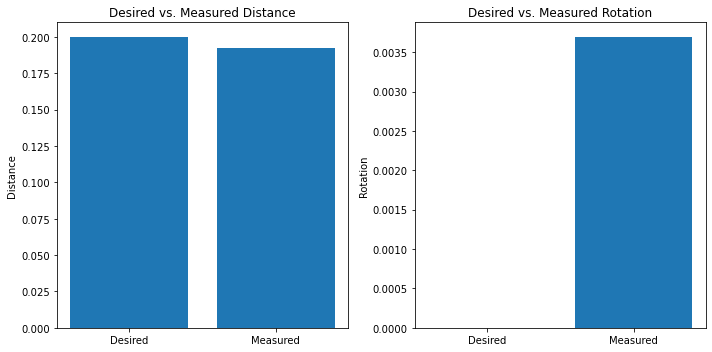

In [20]:
import numpy as np
import eigenpy
import matplotlib.pyplot as plt

# Given data (replace these values with your actual data)
velocity_x = 0.1
velocity_phi = 0.0
duration = 2.0

# Calculate desired distance and rotation
desired_distance = velocity_x * duration

# Define a function to calculate the angular distance between two quaternions
def angular_distance(q1, q2):
    return eigenpy.Quaternion(q1).angularDistance(eigenpy.Quaternion(q2))

# Calculate desired rotation
desired_rotation = velocity_phi * duration

# Sample data (replace these values with your actual data)
pose1_position = np.array([1.1809054613113403, -1.800580620765686])  
pose2_position = np.array([1.1232298612594604, -1.9839327335357666])  
pose1_orientation = np.array([-0.001508902758359909, 2.1100277081131935e-05, -0.8044115900993347, 0.594070553779602])  # Replace with actual pose1 orientation (w, x, y, z)
pose2_orientation = np.array([-0.0030553662218153477, -0.0009766248986124992, -0.8045011162757874, 0.5939425230026245])  # Replace with actual pose2 orientation (w, x, y, z)

# Calculate measured distance and rotation
measured_distance = np.sqrt((pose1_position[0] - pose2_position[0]) ** 2 + (pose1_position[1] - pose2_position[1]) ** 2)
measured_rotation = angular_distance(pose1_orientation, pose2_orientation)

# Calculate differences
distance_difference = desired_distance - measured_distance
rotation_difference = desired_rotation - measured_rotation

# Plot the differences
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['Desired', 'Measured'], [desired_distance, measured_distance])
plt.ylabel('Distance')
plt.title('Desired vs. Measured Distance')

plt.subplot(1, 2, 2)
plt.bar(['Desired', 'Measured'], [desired_rotation, measured_rotation])
plt.ylabel('Rotation')
plt.title('Desired vs. Measured Rotation')

plt.tight_layout()
plt.show()
